# Problem Statement
Mobile game app developers often struggle with determining the optimal **price** for their games, as well as how to structure **in-app purchases (IAPs)** to balance profitability with user satisfaction With users becoming increasingly price-sensitive and many opting for free apps, finding the right price point is crucial for balancing revenue generation with download volume. While apps priced too high may reduce user downloads, pricing too low or free without a well-designed IAP strategy can limit revenue potential. 

This project leverages the 17K Apple App Store Strategy Games dataset to develop machine learning models that predict:
- The **price** of an app based on its features (e.g., genre, ratings, app size, release dates)
- The **average value of in-app purchases (IAP mean)** for a game to guide monetization strategy.

[🔗 View the dataset on Kaggle](https://www.kaggle.com/datasets/tristan581/17k-apple-app-store-strategy-games)


# Scope Refinement
While the initial goal was to predict app price based on metadata, EDA reveals that the dataset was heavily skewed as more than 83% of apps are free. This imbalance severely limited the model's ability to accurately predict price and reduced the practical value of the output. Hence, the project scope was refined to focus on predicting the average in-app purchase amount (IAPMean), as it is less skewed and provides more practical value for understanding app monetization strategies. This shift not only addresses the class imbalance but also better reflects modern monetization strategies used by game developers.

In [1]:
!pip install -r requirements.txt

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import random
from datetime import datetime
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
import matplotlib as mpl   

# Preprocessing
from sklearn.preprocessing import (
    MultiLabelBinarizer, OneHotEncoder, LabelEncoder,
    normalize, StandardScaler
)
from sklearn import preprocessing

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_score, recall_score, f1_score
)
from sklearn import metrics

# Regressors
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Stats
from scipy import stats
from scipy.stats import randint, uniform


In [2]:
#import dataset
games_df = pd.read_csv("appstore_games.csv")
games_df.columns = games_df.columns.str.strip().str.replace(' ', '')
games_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        17007 non-null  object 
 1   ID                         17007 non-null  int64  
 2   Name                       17007 non-null  object 
 3   Subtitle                   5261 non-null   object 
 4   IconURL                    17007 non-null  object 
 5   AverageUserRating          7561 non-null   float64
 6   UserRatingCount            7561 non-null   float64
 7   Price                      16983 non-null  float64
 8   In-appPurchases            7683 non-null   object 
 9   Description                17007 non-null  object 
 10  Developer                  17007 non-null  object 
 11  AgeRating                  17007 non-null  object 
 12  Languages                  16947 non-null  object 
 13  Size                       17006 non-null  flo

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# overview of the dataset
games_df.head(5)

,URL,ID,Name,Subtitle,IconURL,AverageUserRating,UserRatingCount,Price,In-appPurchases,Description,Developer,AgeRating,Languages,Size,PrimaryGenre,Genres,OriginalReleaseDate,CurrentVersionReleaseDate
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


# Data Cleaning

In [5]:
# Remove unnecessary columns
games_df = games_df.drop(columns=['Description', 'ID', 'URL', 'IconURL', 'Name'])

In [6]:
missing_percent = games_df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].round(2)

print("Percentage of missing values per column:\n")
print(missing_percent.sort_values(ascending=False))

Percentage of missing values per column:

Subtitle             69.07
AverageUserRating    55.54
UserRatingCount      55.54
In-appPurchases      54.82
Languages             0.35
Price                 0.14
Size                  0.01
dtype: float64


We first addressed the columns with the highest proportion of missing values: `AverageUserRating`, `UserRatingCount`, and `In-appPurchases`.

- **AverageUserRating**: Missing values likely indicate that the app has not received any user ratings. Since this column is used as a feature in our price prediction model, we dropped rows where this value is missing to avoid introducing noise or assumptions.

- **UserRatingCount**: Like `AverageUserRating`, missing `UserRatingCount` likely means the app hasn't received any ratings. These missing values are removed with `AverageUserRating` to ensure consistency.

- **In-appPurchases**: Missing values suggest that as the app not offering any in-app purchases. Instead of dropping these rows, we replaced `NaN` with different columns:
  - `IAP_Count`: Number of in-app purchase items (0 if none)
  - `IAP_Mean`: Average price of IAPs (0 if none)


In [7]:

# Fill NaN with empty strings to safely parse
iap_clean = games_df['In-appPurchases'].fillna('')

# Define a function to extract count, mean, and binary flag
def extract_iap_features(iap_str):
    if not iap_str.strip():  
        return pd.Series([0, 0.0]) 

    try:
        prices = [float(p.strip()) for p in iap_str.split(',') if p.strip()]
        count = len(prices)
        mean = np.mean(prices)
        return pd.Series([count, mean])
    except:
        return pd.Series([0, 0.0])

# Apply the function to create columns
games_df[['IAPCount', 'IAPMean']] = iap_clean.apply(extract_iap_features)

# Drop original In-appPurchases column
games_df = games_df.drop(['In-appPurchases'], axis=1)

In [8]:
# Drop nan values for AverageUserRating and UserRatingCount
games_df = games_df.dropna(subset=['AverageUserRating'])
games_df = games_df[games_df['UserRatingCount'] > 0]

In [9]:
#Fill in data with mean or mode
games_df['Languages'].fillna(games_df['Languages'].value_counts().index[0],inplace= True)
games_df['Size'].fillna(games_df['Size'].mean(),inplace=True)
games_df['Price'].fillna(games_df['Price'].value_counts().index[0],inplace= True)


In [10]:
# Add column to count number of language
games_df['LanguageCount'] = games_df['Languages'].fillna('').apply(
    lambda x: len([lang.strip() for lang in x.split(',') if lang.strip()])
)

In [11]:
games_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7561 entries, 0 to 16993
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Subtitle                   2724 non-null   object 
 1   AverageUserRating          7561 non-null   float64
 2   UserRatingCount            7561 non-null   float64
 3   Price                      7561 non-null   float64
 4   Developer                  7561 non-null   object 
 5   AgeRating                  7561 non-null   object 
 6   Languages                  7561 non-null   object 
 7   Size                       7561 non-null   float64
 8   PrimaryGenre               7561 non-null   object 
 9   Genres                     7561 non-null   object 
 10  OriginalReleaseDate        7561 non-null   object 
 11  CurrentVersionReleaseDate  7561 non-null   object 
 12  IAPCount                   7561 non-null   float64
 13  IAPMean                    7561 non-null   floa

# Data Visualisation

### Price

First, we try to find out some basic statistic of the price.​



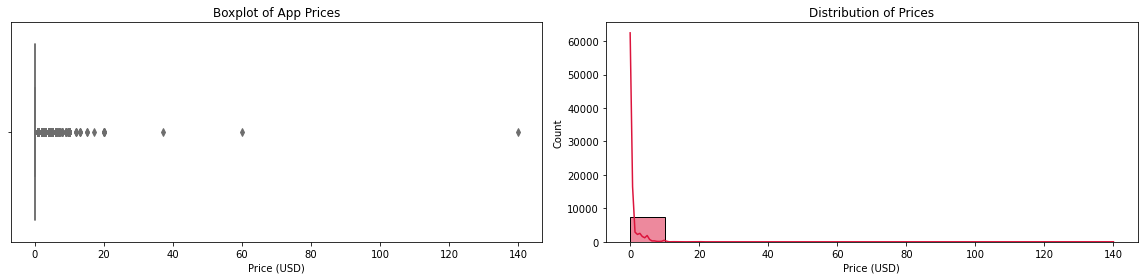

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Boxplot
sns.boxplot(x=games_df['Price'], color='salmon', ax=axes[0])
axes[0].set_title('Boxplot of App Prices')
axes[0].set_xlabel('Price (USD)')

# Distribution plot
sns.histplot(games_df['Price'], kde=True, color='crimson', ax=axes[1])
axes[1].set_title('Distribution of Prices')
axes[1].set_xlabel('Price (USD)')

plt.tight_layout()
plt.show()

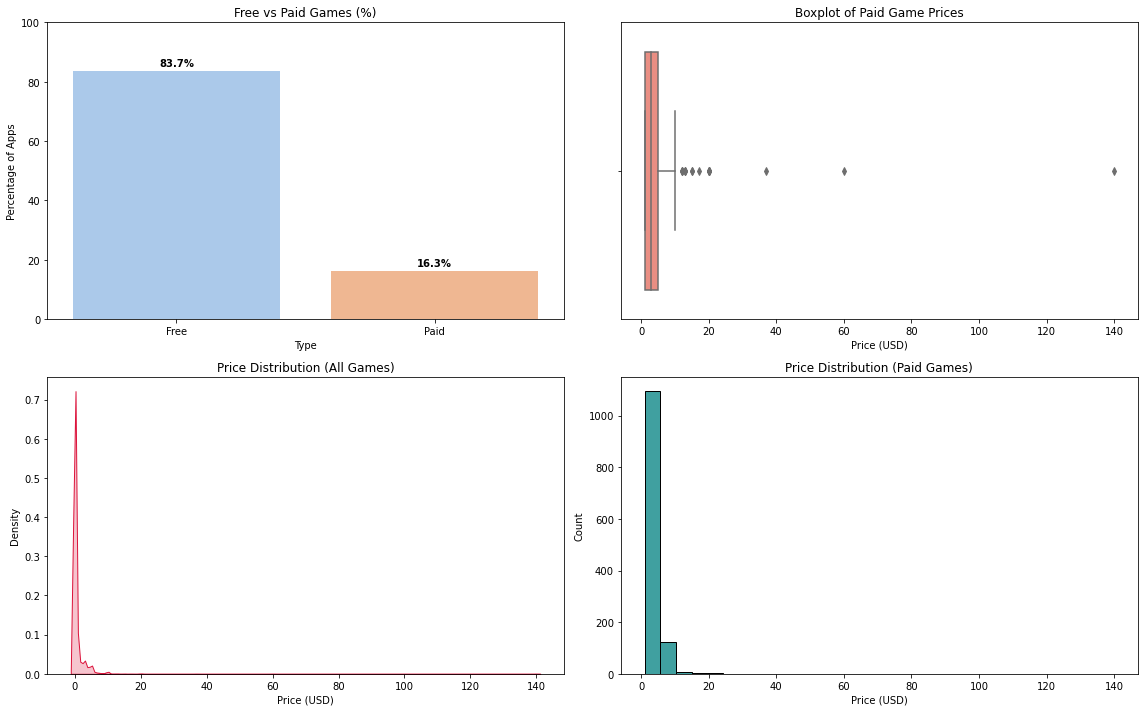

In [13]:
# Create filtered datasets
free_paid = games_df.copy()
free_paid['IsFree'] = free_paid['Price'] == 0
paid_games = games_df[games_df['Price'] > 0]
all_prices = games_df['Price']
paid_prices = paid_games['Price']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Compute percentage of free vs paid
price_group = free_paid['IsFree'].value_counts(normalize=True).rename({True: 'Free', False: 'Paid'}) * 100
price_df = price_group.reset_index()
price_df.columns = ['Type', 'Percentage']

# Plot 1: Bar chart of Free vs Paid
sns.barplot(x='Type', y='Percentage', data=price_df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Free vs Paid Games (%)')
axes[0, 0].set_ylabel('Percentage of Apps')
axes[0, 0].set_ylim(0, 100)

# Add labels on top of bars
for i, row in price_df.iterrows():
    axes[0, 0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%", ha='center', va='bottom', fontweight='bold')

# Plot 2: Boxplot of Paid Games
sns.boxplot(x=paid_prices, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of Paid Game Prices')
axes[0, 1].set_xlabel('Price (USD)')

# Plot 3: Line chart (KDE) of All Prices
sns.kdeplot(all_prices, ax=axes[1, 0], color='crimson', fill=True)
axes[1, 0].set_title('Price Distribution (All Games)')
axes[1, 0].set_xlabel('Price (USD)')

# Plot 4: Histogram of Paid Prices
sns.histplot(paid_prices, ax=axes[1, 1], color='teal', bins=30, kde=False)
axes[1, 1].set_title('Price Distribution (Paid Games)')
axes[1, 1].set_xlabel('Price (USD)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [14]:
# Apply log transform
games_df['LogPrice'] = np.log1p(games_df['Price'])

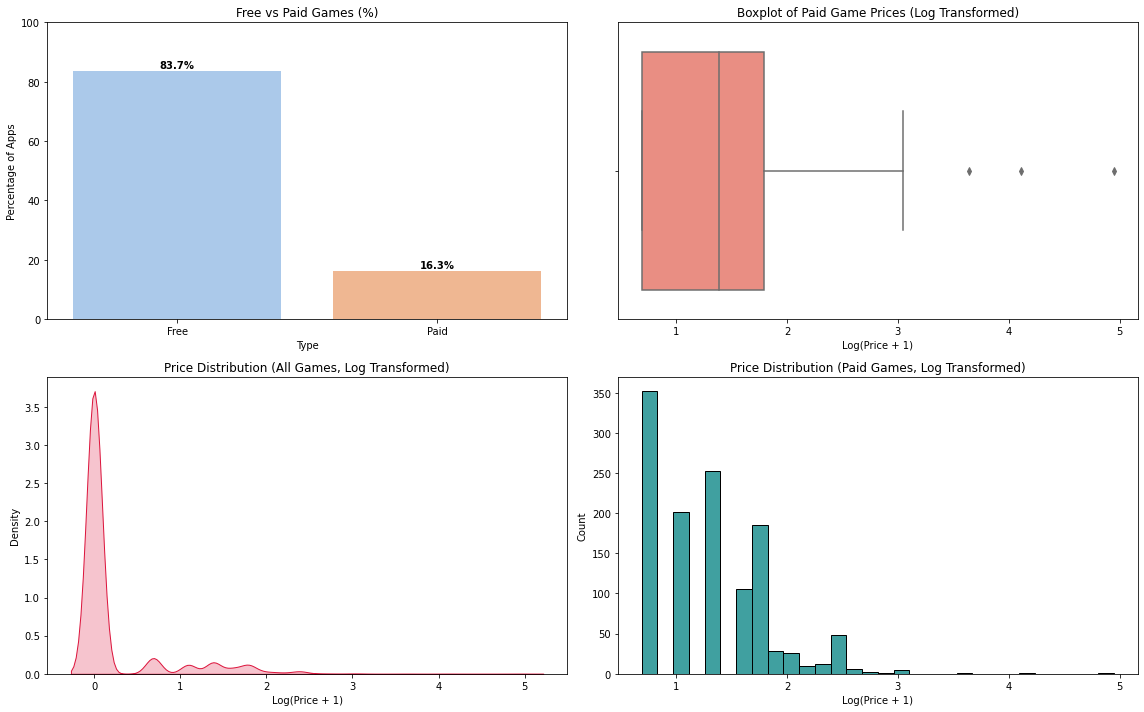

In [15]:

# Create derived columns
free_paid = games_df.copy()
free_paid['IsFree'] = free_paid['LogPrice'] == 0
paid_games = free_paid[~free_paid['IsFree']]
all_prices = free_paid['LogPrice']
paid_prices = paid_games['LogPrice']

# Create Free vs Paid percentage dataframe
price_group = free_paid['IsFree'].value_counts(normalize=True).rename({True: 'Free', False: 'Paid'}) * 100
price_df = price_group.reset_index()
price_df.columns = ['Type', 'Percentage']

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Bar chart - Free vs Paid (%)
sns.barplot(x='Type', y='Percentage', data=price_df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Free vs Paid Games (%)')
axes[0, 0].set_ylabel('Percentage of Apps')
axes[0, 0].set_ylim(0, 100)
for i, row in price_df.iterrows():
    axes[0, 0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%", ha='center', fontweight='bold')

# Plot 2: Boxplot - LogPrice of Paid Games
sns.boxplot(x=paid_prices, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of Paid Game Prices (Log Transformed)')
axes[0, 1].set_xlabel('Log(Price + 1)')

# Plot 3: KDE - LogPrice for All Games
sns.kdeplot(all_prices, ax=axes[1, 0], color='crimson', fill=True)
axes[1, 0].set_title('Price Distribution (All Games, Log Transformed)')
axes[1, 0].set_xlabel('Log(Price + 1)')

# Plot 4: Histogram - LogPrice for Paid Games
sns.histplot(paid_prices, ax=axes[1, 1], color='teal', bins=30)
axes[1, 1].set_title('Price Distribution (Paid Games, Log Transformed)')
axes[1, 1].set_xlabel('Log(Price + 1)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()



### Age Rating

We try to find out whether age rating affects the price and IAPMean of games_df, by comparing the mean price and IAP of different categories of age rating.

The mean price for different categories of age rating:

In [16]:

# get mean price of each age rating category
age_price = games_df.groupby("AgeRating")["Price"].mean().reset_index()
age_price

,AgeRating,Price
0,12+,0.892041
1,17+,0.300104
2,4+,0.472266
3,9+,0.634654


In [17]:
age_price.describe()

,Price
count,4.000000
mean,0.574766
std,0.251790
min,0.300104
25%,0.429225
50%,0.553460
75%,0.699000
max,0.892041


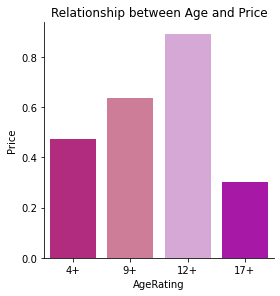

In [18]:
# assign different colours to the bars
palette = ["plum","m","mediumvioletred","palevioletred"]  

# arrange age in ascending order
order = ['4+', '9+', '12+', '17+']

# generate bar graph
age_rating = sns.catplot(x="AgeRating",y="Price", data=age_price, kind="bar", palette=palette, hue="AgeRating", dodge=False,height=4, aspect=1,order=order)
plt.title('Relationship between Age and Price', fontsize = 12)
plt.show()

We can see from the bar graph that the average price of games_df rose from 4+ to 9+, but showed an inverse relationship with age rating starting at 9+. The average price was the highest at age rating 9+ which is around 3 times higher than the other 3 categories.

In [19]:
# get mean price of each age rating category
age_IAP = games_df.groupby("AgeRating")["IAPMean"].mean().reset_index()
age_IAP

,AgeRating,IAPMean
0,12+,9.424213
1,17+,6.988903
2,4+,3.371805
3,9+,7.970326


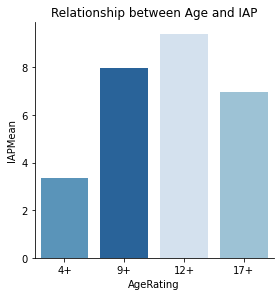

In [20]:
# assign different colours to the bars
palette = sns.color_palette("Blues", n_colors=4)

# generate bar graph
age_rating = sns.catplot(x="AgeRating",y="IAPMean", data=age_IAP, kind="bar", palette=palette, hue="AgeRating", dodge=False, height=4, aspect=1,order=order)
plt.title('Relationship between Age and IAP', fontsize = 12)
plt.show()

### Languages

We try to find out whether number of languages affects the price of games_df.


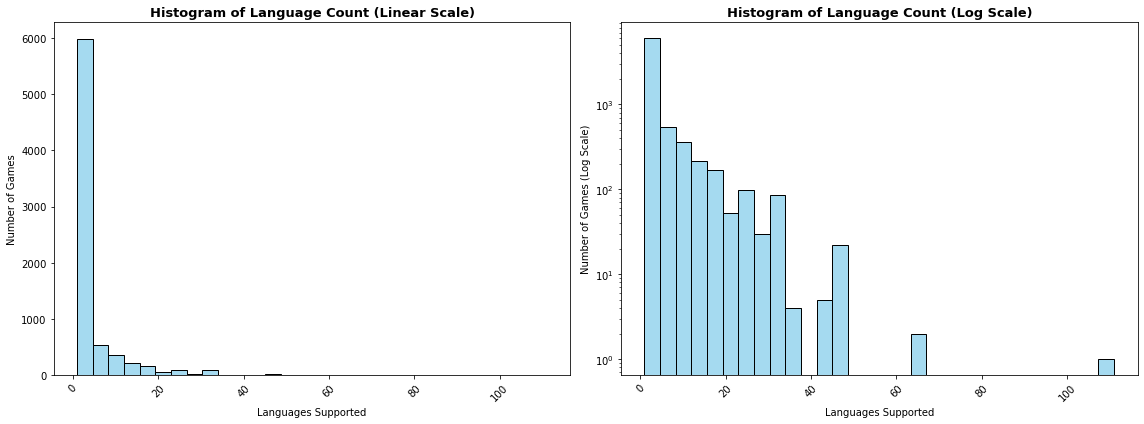

In [21]:
# Count number of apps by language count
lang_count_dist = games_df['LanguageCount'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram - Linear Scale
sns.histplot(games_df['LanguageCount'], bins=30, kde=False, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Language Count (Linear Scale)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Languages Supported')
axes[0].set_ylabel('Number of Games')
axes[0].tick_params(axis='x', rotation=45)

# Histogram - Log Scale
sns.histplot(games_df['LanguageCount'], bins=30, kde=False, color='skyblue', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Histogram of Language Count (Log Scale)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Languages Supported')
axes[1].set_ylabel('Number of Games (Log Scale)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [22]:
games_df["LanguageCount"].describe()

count    7561.000000
mean        3.818675
std         6.525615
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       111.000000
Name: LanguageCount, dtype: float64

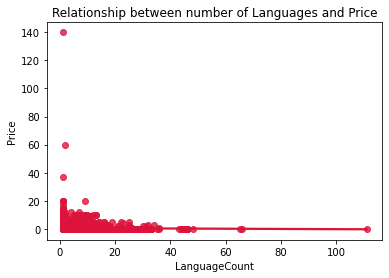

In [23]:
# create a regplot(scatter plot and the fitting line)
sns.regplot(x='LanguageCount', y='Price', data=games_df, color='crimson')
plt.title("Relationship between number of Languages and Price")
plt.show()

From the scatter plot above, we observe a very flat declining line. We can say that there is a very weak inverse relationship between price and number of languages

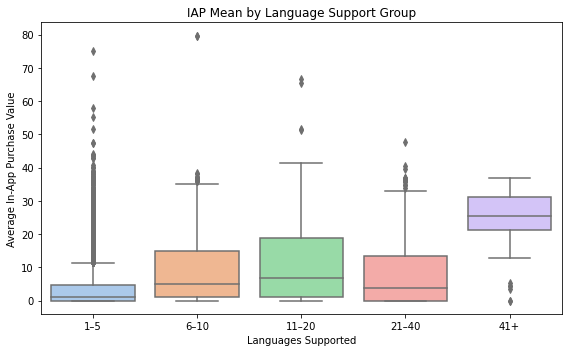

In [24]:
# Create bins
games_df['Lang_Bin'] = pd.cut(games_df['LanguageCount'], bins=[0, 5, 10, 20, 40, 100], labels=['1–5', '6–10', '11–20', '21–40', '41+'])

plt.figure(figsize=(8, 5))
sns.boxplot(x='Lang_Bin', y='IAPMean', data=games_df, palette='pastel')
plt.title('IAP Mean by Language Support Group')
plt.xlabel('Languages Supported')
plt.ylabel('Average In-App Purchase Value')
plt.tight_layout()
plt.show()


As the number of supported languages increases, the median in-app purchase value (IAP Mean) tends to increase. While there is a general upward trend in IAP Mean as language support increases, the relationship is not strictly linear.




### Original and Current Version Release Date 

In [25]:
# Convert to datetime format
games_df['OriginalReleaseDate'] = pd.to_datetime(games_df['OriginalReleaseDate'], dayfirst=True, errors='coerce')
games_df['CurrentVersionReleaseDate'] = pd.to_datetime(games_df['CurrentVersionReleaseDate'], dayfirst=True, errors='coerce')

# Extract the year
games_df['OriginalReleaseYear'] = games_df['OriginalReleaseDate'].dt.year
games_df['CurrentVersionReleaseYear'] = games_df['CurrentVersionReleaseDate'].dt.year


We extracted the years from the dates.

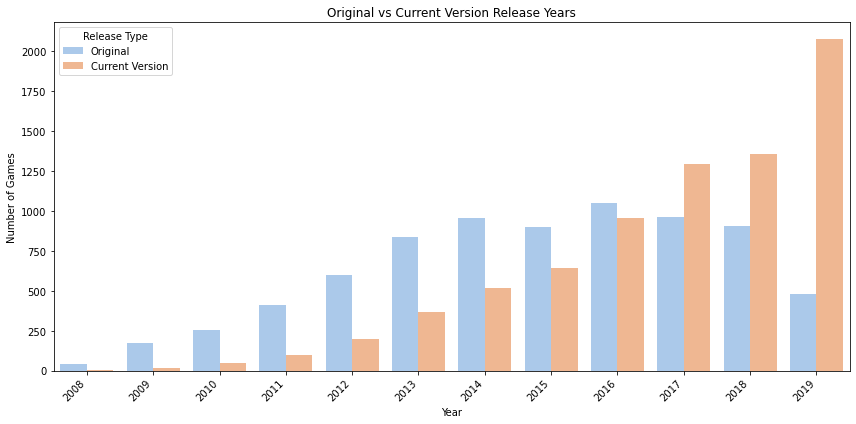

In [26]:
# Melt the year columns into one
release_years = pd.melt(
    games_df,
    id_vars=[],  
    value_vars=['OriginalReleaseYear', 'CurrentVersionReleaseYear'],
    var_name='ReleaseType',
    value_name='Year'
)

# Rename values
release_years['ReleaseType'] = release_years['ReleaseType'].replace({
    'OriginalReleaseYear': 'Original',
    'CurrentVersionReleaseYear': 'Current Version'
})

plt.figure(figsize=(12, 6))
sns.countplot(data=release_years, x='Year', hue='ReleaseType', palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.title('Original vs Current Version Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.legend(title='Release Type')
plt.tight_layout()
plt.show()

In [27]:
# Calculate the means 
org_year_mean = games_df.groupby("OriginalReleaseYear")["Price"].mean().reset_index()
cur_year_mean = games_df.groupby("CurrentVersionReleaseYear")["Price"].mean().reset_index()

# Rename columns
org_year_mean.columns = ['Year', 'OriginalMeanPrice']
cur_year_mean.columns = ['Year', 'CurrentMeanPrice']

# Merge the two DataFrames on 'Year'
price_comparison = pd.merge(org_year_mean, cur_year_mean, on='Year', how='outer').sort_values('Year')
price_comparison

,Year,OriginalMeanPrice,CurrentMeanPrice
0,2008,1.494318,0.000000
1,2009,0.926163,0.058235
2,2010,1.109804,0.129783
3,2011,0.824684,0.207604
4,2012,0.648344,0.174000
5,2013,0.680970,0.162527
6,2014,0.548283,0.146531
7,2015,0.541860,0.567094
8,2016,0.475349,0.671532
9,2017,0.438631,0.703315


We computed the mean price for each year.

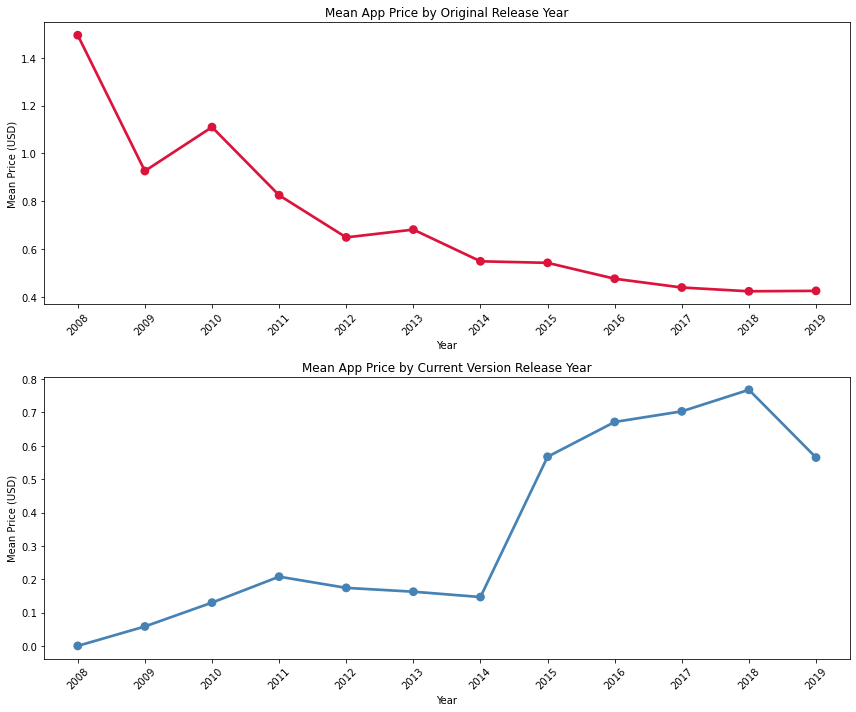

In [28]:
# Create 2x1 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False)

# Original Release Year Plot
sns.pointplot(data=org_year_mean, x='Year', y='OriginalMeanPrice', ax=axes[0], color='crimson')
axes[0].set_title("Mean App Price by Original Release Year")
axes[0].set_ylabel("Mean Price (USD)")
axes[0].tick_params(axis='x', rotation=45)

# Current Version Release Year Plot
sns.pointplot(data=cur_year_mean, x='Year', y='CurrentMeanPrice', ax=axes[1], color='steelblue')
axes[1].set_title("Mean App Price by Current Version Release Year")
axes[1].set_ylabel("Mean Price (USD)")
axes[1].set_xlabel("Year")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [29]:
# Calculate the means 
org_year_mean = games_df.groupby("OriginalReleaseYear")["IAPMean"].mean().reset_index()
cur_year_mean = games_df.groupby("CurrentVersionReleaseYear")["IAPMean"].mean().reset_index()

# Rename columns
org_year_mean.columns = ['Year', 'OriginalMeanIAP']
cur_year_mean.columns = ['Year', 'CurrentMeanIAP']

# Merge the two DataFrames on 'Year'
price_comparison = pd.merge(org_year_mean, cur_year_mean, on='Year', how='outer').sort_values('Year')

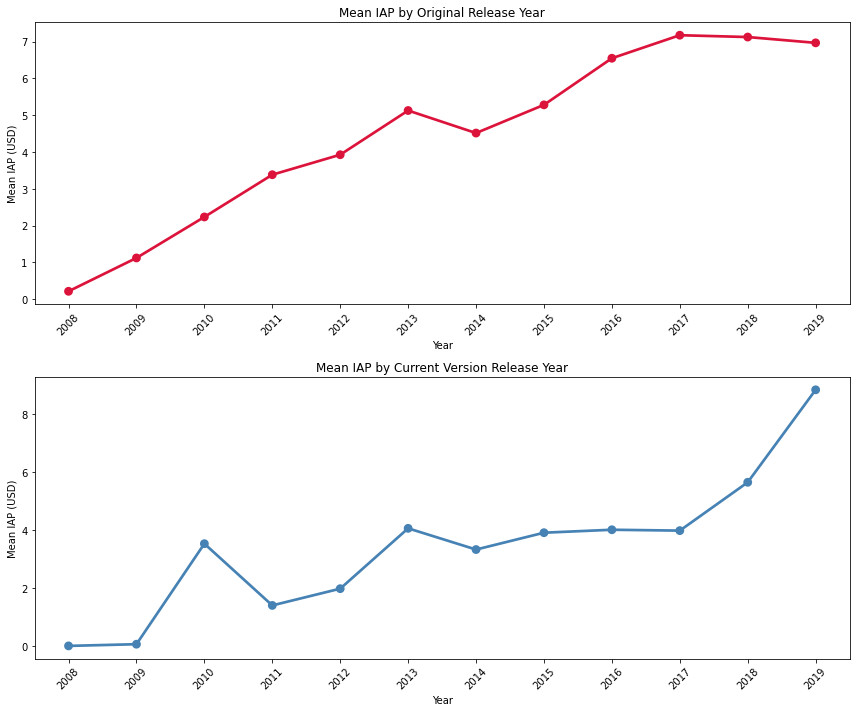

In [30]:
# Create 2x1 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False)

# Original Release Year Plot
sns.pointplot(data=org_year_mean, x='Year', y='OriginalMeanIAP', ax=axes[0], color='crimson')
axes[0].set_title("Mean IAP by Original Release Year")
axes[0].set_ylabel("Mean IAP (USD)")
axes[0].tick_params(axis='x', rotation=45)

# Current Version Release Year Plot
sns.pointplot(data=cur_year_mean, x='Year', y='CurrentMeanIAP', ax=axes[1], color='steelblue')
axes[1].set_title("Mean IAP by Current Version Release Year")
axes[1].set_ylabel("Mean IAP (USD)")
axes[1].set_xlabel("Year")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Primary Genre

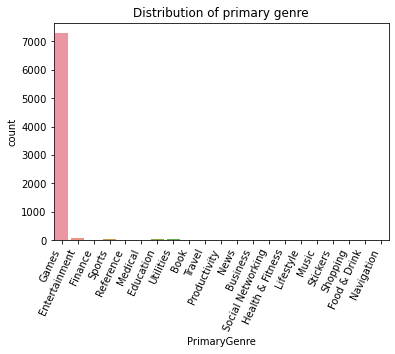

In [31]:
# find the distribution of primary genre
sns.countplot(x="PrimaryGenre",data=games_df,)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title("Distribution of primary genre")
plt.show()

In [32]:
# find out the mean price for each primary genre, using groupby()
mean_ge = games_df.groupby("PrimaryGenre")["Price"].mean().reset_index()
mean_ge.head()

,PrimaryGenre,Price
0,Book,0.000000
1,Business,4.995000
2,Education,2.104130
3,Entertainment,0.216196
4,Finance,17.498750


Above are the mean price for each primary genre.

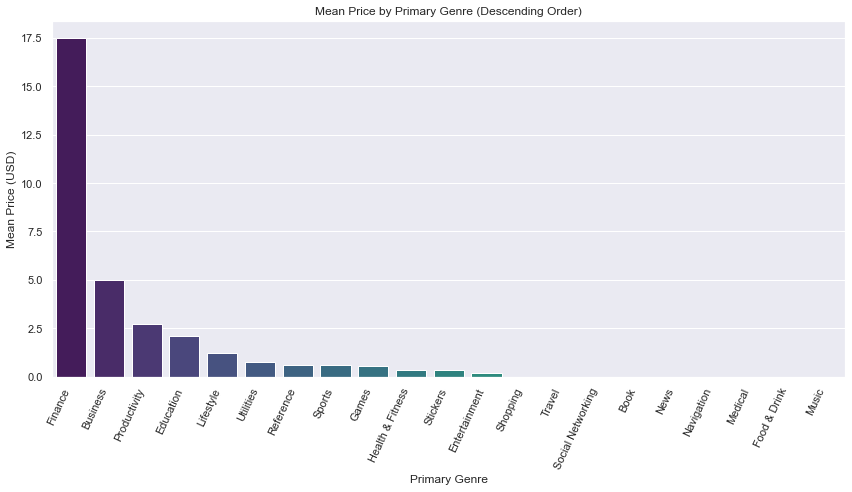

In [33]:

# Sort the data by mean price descending
mean_ge_sorted = mean_ge.sort_values(by="Price", ascending=False)

sns.set(rc={'figure.figsize': (12, 7)})

# plot the graph of all genres
ax = sns.barplot(x="PrimaryGenre", y="Price", data=mean_ge_sorted, palette="viridis")

plt.xticks(rotation=65, horizontalalignment='right')
plt.title("Mean Price by Primary Genre (Descending Order)")
plt.ylabel("Mean Price (USD)")
plt.xlabel("Primary Genre")
plt.tight_layout()
plt.show()

For primary genre, from the graph, apps of business have highest price (around $5), and out of 21 primary genres, 9 are free.

In [34]:
# find out the mean IAp for each primary genre, using groupby()
mean_iap_ge = games_df.groupby("PrimaryGenre")["IAPMean"].mean().reset_index()
mean_iap_ge.head()

,PrimaryGenre,IAPMean
0,Book,6.520000
1,Business,5.995000
2,Education,1.686884
3,Entertainment,2.326486
4,Finance,14.617778


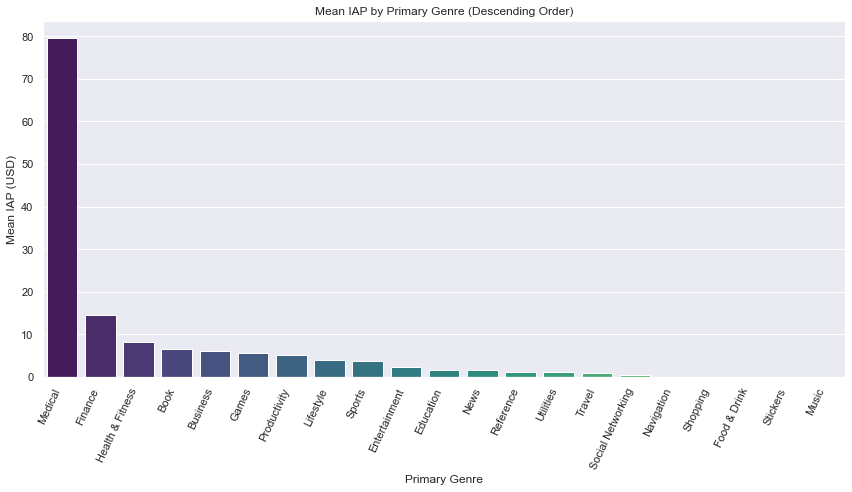

In [35]:
# Sort the data by mean IAP descending
mean_iap_ge_sorted = mean_iap_ge.sort_values(by="IAPMean", ascending=False)

sns.set(rc={'figure.figsize': (12, 7)})

# plot the graph of all genres
ax = sns.barplot(x="PrimaryGenre", y="IAPMean", data=mean_iap_ge_sorted, palette="viridis")

plt.xticks(rotation=65, horizontalalignment='right')
plt.title("Mean IAP by Primary Genre (Descending Order)")
plt.ylabel("Mean IAP (USD)")
plt.xlabel("Primary Genre")
plt.tight_layout()
plt.show()

### Genres

In [36]:
# Fill NaN
games_df['Genres'] = games_df['Genres'].fillna('')
games_df['PrimaryGenre'] = games_df['PrimaryGenre'].fillna('')

# Split genres into a list
games_df['GenresList'] = games_df['Genres'].apply(lambda x: [g.strip() for g in x.split(',')])

# Remove the primary genre from the list
games_df['GenresList'] = games_df.apply(
    lambda row: [g for g in row['GenresList'] if g.lower() != row['PrimaryGenre'].lower()],
    axis=1
)

games_df['GenresList'].head(5)

0              [Strategy, Puzzle]
1               [Strategy, Board]
2               [Board, Strategy]
3              [Strategy, Puzzle]
4    [Strategy, Board, Education]
Name: GenresList, dtype: object

Above are the sub genres without their primary genre.

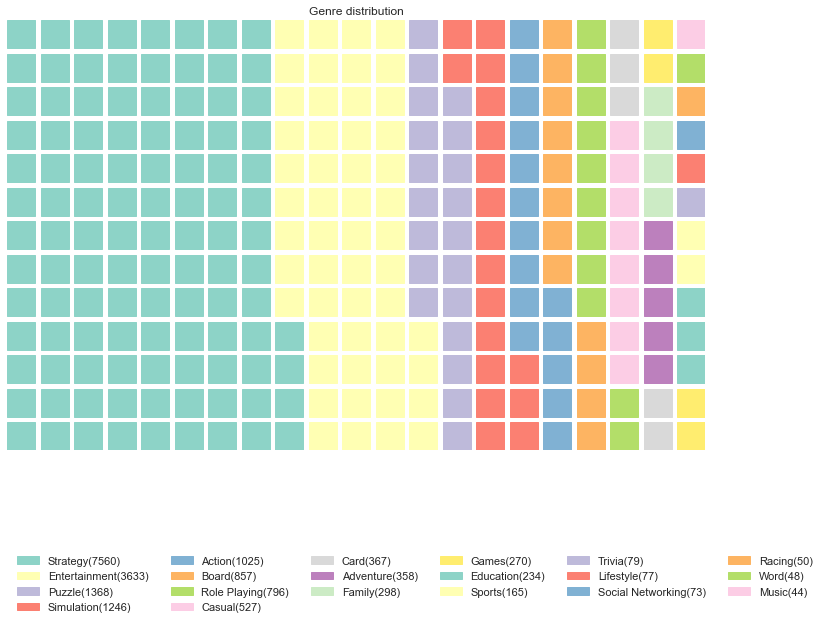

In [37]:
# show the distribution
genre_list = games_df['GenresList']
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(genre_list), columns=mlb.classes_, index=genre_list.index)

# assign colour palette
color = sns.color_palette('Set3', n_colors=20).as_hex()

y = res.apply(sum).sort_values(ascending=False)[:20]

fig = plt.figure(
    FigureClass=Waffle, 
    rows=13, 
    columns=21, 
    values=y,
    labels=["{}({})".format(a, b) for a, b in zip(y.index, y) ],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(y)//3,  'framealpha': 0},
    font_size=20, 
    figsize=(12, 12),  
    icon_legend=True,
    colors=color
    )

plt.title('Genre distribution')

plt.show()

We can see that all apps include 'strategy' and the top 3 genres are 'entertainment', 'puzzle', and 'simulation'.

In [38]:
# Create dummy columns from the 'Genres' column
Genres_dummies = games_df['Genres'].str.get_dummies(sep=', ').add_prefix('Genres_')

# Concatenate the dummies to the original DataFrame
games_df = pd.concat([games_df.reset_index(drop=True), Genres_dummies.reset_index(drop=True)], axis=1)

# Get the top 10 most common genres
top_genres = Genres_dummies.sum().sort_values(ascending=False).head(10).index.tolist()

# Compute mean price for apps that have and don't have each genre
genre_price_means = []

for genre_col in top_genres:
    grouped = games_df.groupby(genre_col)['Price'].mean()
    genre_price_means.append({
        'Genre': genre_col.replace('Genres_', ''),
        'Has Genre': grouped.get(1, 0),
        'No Genre': grouped.get(0, 0)
    })

# Convert the result to a DataFrame
genre_price_df = pd.DataFrame(genre_price_means)
genre_price_df = genre_price_df[~genre_price_df['Genre'].isin(['Games', 'Strategy'])]
print(genre_price_df)

           Genre  Has Genre  No Genre
2  Entertainment   0.507136  0.633618
3         Puzzle   0.325212  0.625666
4     Simulation   0.812705  0.523675
5         Action   0.375249  0.602052
6          Board   1.268996  0.482117
7   Role Playing   0.677952  0.558757
8         Casual   0.149184  0.602931
9           Card   0.687684  0.565368


The mean prices for the top 6 genres are found out as follows:

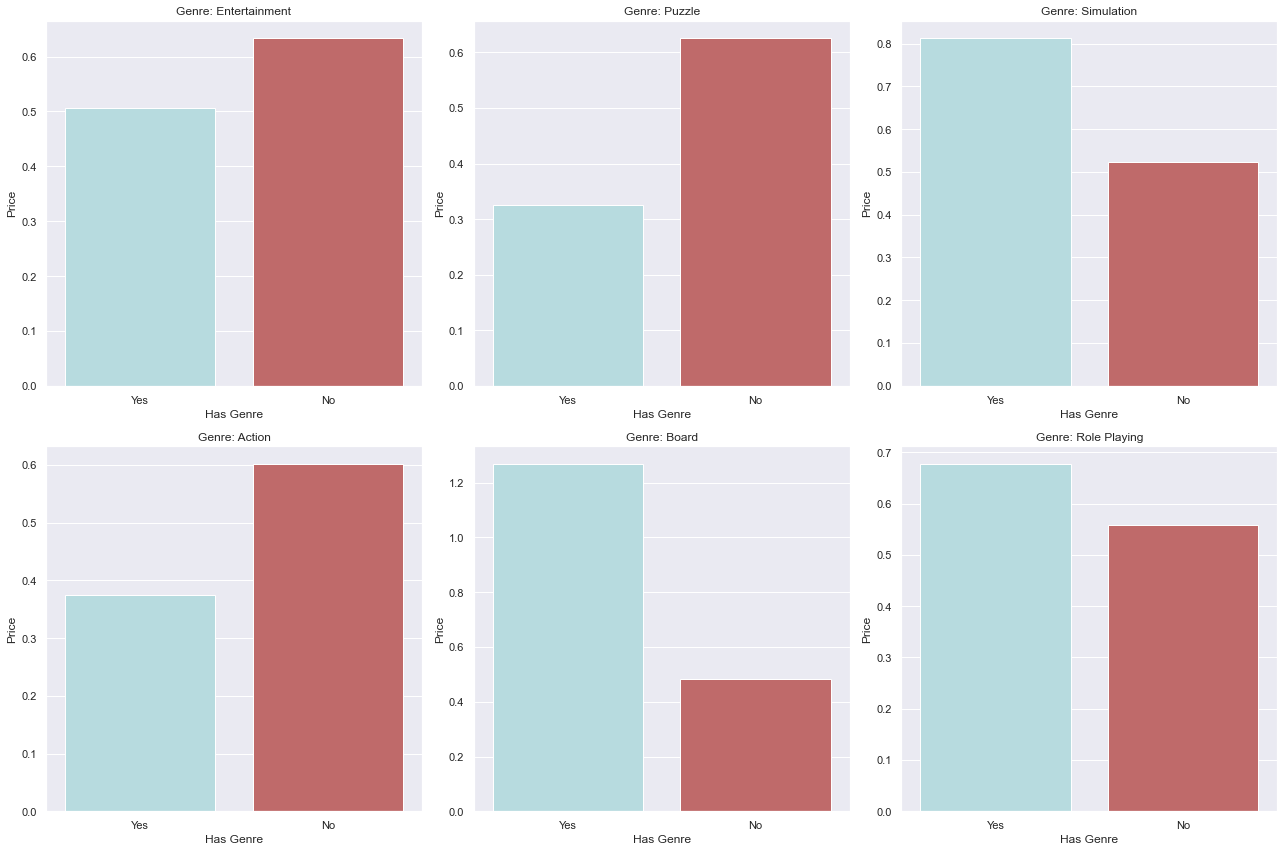

In [39]:
# Select top 6 by 'Has Genre' count 
top6_genres = genre_price_df.reset_index().head(6) 

# Setup plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
palette = ['powderblue', 'indianred']

# Plot each genre dynamically
for i, row in top6_genres.iterrows():
    genre = row['Genre']
    data = pd.DataFrame({
        'Has Genre': ['Yes', 'No'],
        'Price': [row['Has Genre'], row['No Genre']]
    })
    sns.barplot(x='Has Genre', y='Price', data=data, ax=axes[i], palette=palette)
    axes[i].set_title(f"Genre: {genre}")

plt.tight_layout()
plt.show()

In [40]:
# Reuse top_genres and genre filtering from earlier
filtered_top_genres = [g for g in top_genres if g not in ['Genres_Games', 'Genres_Strategy']]

# Compute mean IAPMean for apps that have and don’t have each genre
genre_iap_means = []

for genre_col in filtered_top_genres:
    grouped = games_df.groupby(genre_col)['IAPMean'].mean()
    genre_iap_means.append({
        'Genre': genre_col.replace('Genres_', ''),
        'Has Genre': grouped.get(1, 0),
        'No Genre': grouped.get(0, 0)
    })

# Convert to DataFrame
genre_iap_df = pd.DataFrame(genre_iap_means)
print(genre_iap_df)

           Genre  Has Genre  No Genre
0  Entertainment   5.080899  5.852475
1         Puzzle   2.283333  6.176787
2     Simulation   7.123319  5.146601
3         Action   7.000903  5.232637
4          Board   2.148755  5.897219
5   Role Playing  12.610138  4.632487
6         Casual   3.222171  5.640938
7           Card   5.247386  5.483827


It is found out that among the top6 genres, apps with 'simulation' and 'board' are more expensive, especially for apps with simulation.

### Size

In [41]:
games_df["Size"].describe()

count    7.561000e+03
mean     1.514679e+08
std      2.550380e+08
min      2.158400e+05
25%      3.061862e+07
50%      7.964672e+07
75%      1.776138e+08
max      4.005591e+09
Name: Size, dtype: float64

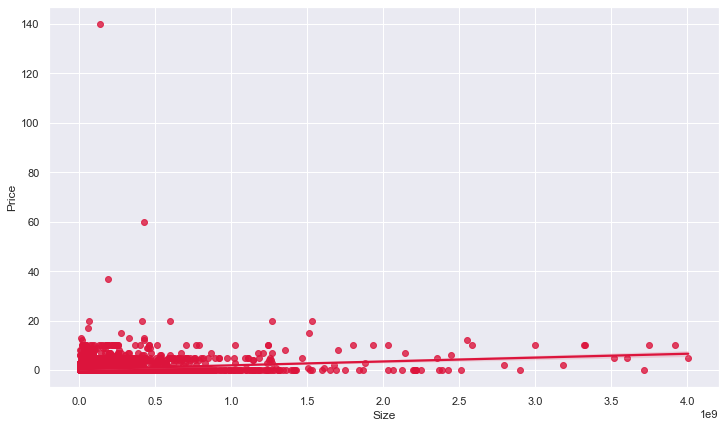

In [42]:
ax = sns.regplot(x='Size',y='Price',data = games_df, color = 'crimson')
ax.set_xlabel('Size')
ax.set_ylabel('Price')
plt.show()

As shown on the scatter plot, there is a slightly positive relationship between price and size, a larger sized game tend to charge a higher price.

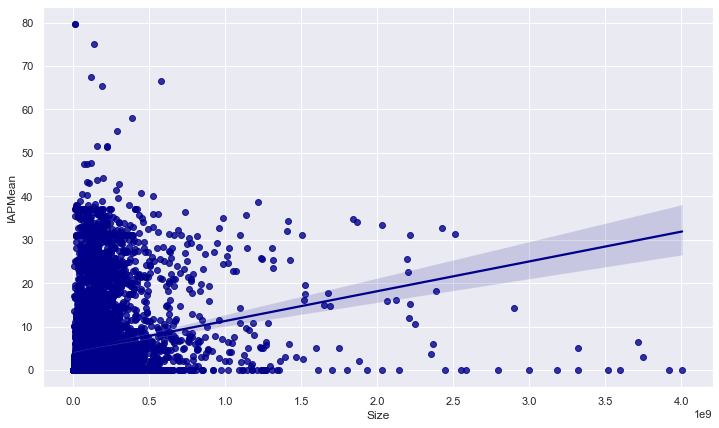

In [43]:
ax = sns.regplot(x='Size',y='IAPMean',data = games_df, color = 'darkblue')
ax.set_xlabel('Size')
ax.set_ylabel('IAPMean')
plt.show()

### Inapp Purchase

We try to find out whether inapp purchase will affect the price and vice versa. 


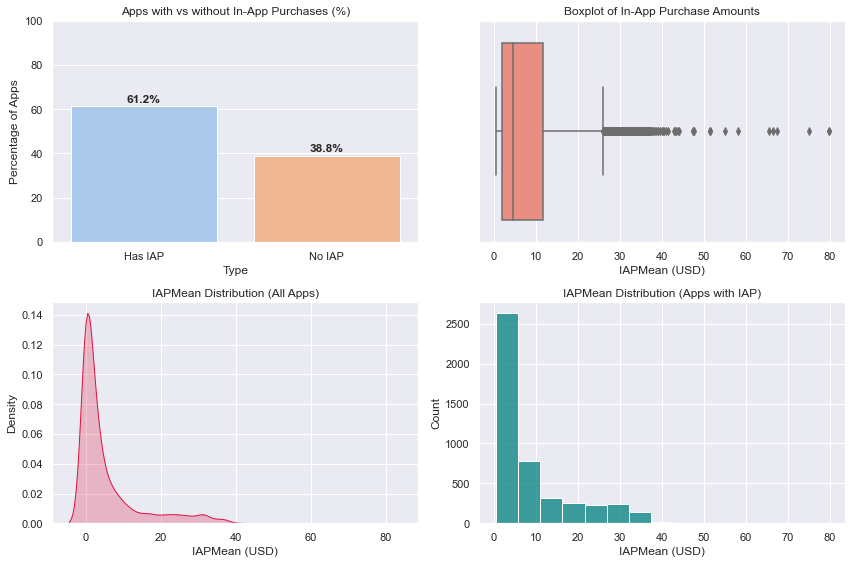

In [44]:
# Create filtered datasets
iap_df = games_df.copy()
iap_df['HasIAP'] = iap_df['IAPMean'] > 0
iap_positive = iap_df[iap_df['IAPMean'] > 0]
all_iap = iap_df['IAPMean']
positive_iap = iap_positive['IAPMean']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Compute percentage of apps with/without IAP
iap_group = iap_df['HasIAP'].value_counts(normalize=True).rename({True: 'Has IAP', False: 'No IAP'}) * 100
iap_percent_df = iap_group.reset_index()
iap_percent_df.columns = ['Type', 'Percentage']

# Plot 1: Bar chart of Has IAP vs No IAP
sns.barplot(x='Type', y='Percentage', data=iap_percent_df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Apps with vs without In-App Purchases (%)')
axes[0, 0].set_ylabel('Percentage of Apps')
axes[0, 0].set_ylim(0, 100)

# Add labels on top of bars
for i, row in iap_percent_df.iterrows():
    axes[0, 0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%", ha='center', va='bottom', fontweight='bold')

# Plot 2: Boxplot of IAPMean for apps with IAP
sns.boxplot(x=positive_iap, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of In-App Purchase Amounts')
axes[0, 1].set_xlabel('IAPMean (USD)')

# Plot 3: KDE of All IAPMean values
sns.kdeplot(all_iap, ax=axes[1, 0], color='crimson', fill=True)
axes[1, 0].set_title('IAPMean Distribution (All Apps)')
axes[1, 0].set_xlabel('IAPMean (USD)')

# Plot 4: Histogram of Positive IAPMean
sns.histplot(positive_iap, ax=axes[1, 1], color='teal', bins=15, kde=False)
axes[1, 1].set_title('IAPMean Distribution (Apps with IAP)')
axes[1, 1].set_xlabel('IAPMean (USD)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()



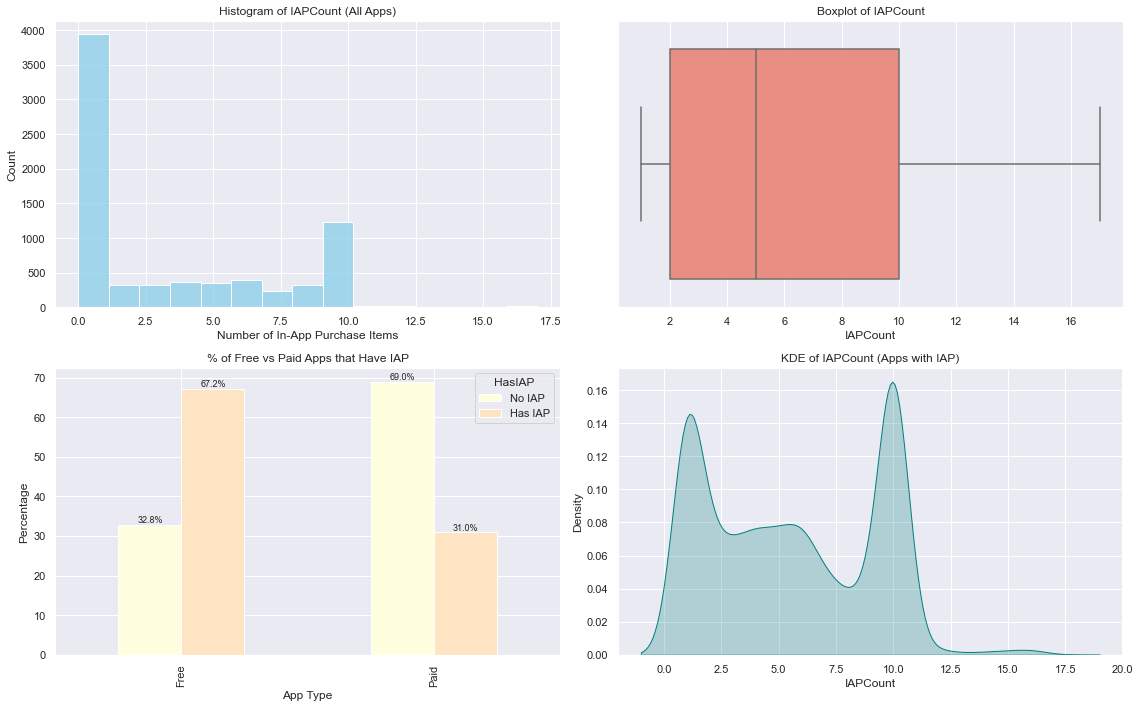

In [45]:
# Copy and prepare data
iap_df = games_df.copy()
iap_df['HasIAP'] = iap_df['IAPCount'] > 0
iap_df['IsFree'] = iap_df['Price'] == 0
iap_positive = iap_df[iap_df['IAPCount'] > 0]
iap_zero = iap_df[iap_df['IAPCount'] == 0]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Plot 1: Histogram of IAPCount ---
sns.histplot(iap_df['IAPCount'], ax=axes[0, 0], bins=15, color='skyblue', kde=False)
axes[0, 0].set_title('Histogram of IAPCount (All Apps)')
axes[0, 0].set_xlabel('Number of In-App Purchase Items')
axes[0, 0].set_ylabel('Count')

# --- Plot 2: Boxplot of IAPCount > 0 ---
sns.boxplot(x=iap_positive['IAPCount'], ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of IAPCount')
axes[0, 1].set_xlabel('IAPCount')

# --- Plot 3: % of Free vs Paid apps that have IAP ---
# Create a crosstab of Price Type vs HasIAP
price_type = iap_df['IsFree'].map({True: 'Free', False: 'Paid'})
iap_by_price = pd.crosstab(price_type, iap_df['HasIAP'], normalize='index') * 100
iap_by_price = iap_by_price.rename(columns={True: 'Has IAP', False: 'No IAP'}).reset_index()

# Plot grouped bar chart
iap_by_price.plot(kind='bar', x='IsFree', stacked=False, ax=axes[1, 0], color=['lightyellow', 'bisque'])
axes[1, 0].set_title('% of Free vs Paid Apps that Have IAP')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('App Type')

# Add percentage labels
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9)

# --- Plot 4: KDE of IAPCount > 0 ---
sns.kdeplot(iap_positive['IAPCount'], ax=axes[1, 1], fill=True, color='teal')
axes[1, 1].set_title('KDE of IAPCount (Apps with IAP)')
axes[1, 1].set_xlabel('IAPCount')

plt.tight_layout()
plt.show()



### Correlation Analysis

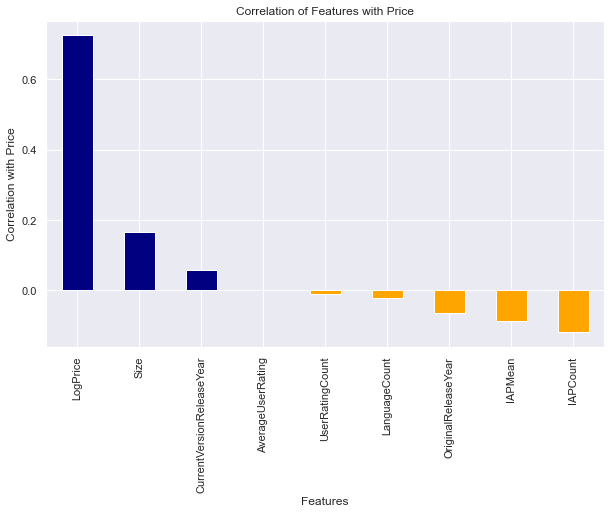

In [46]:
numeric_df = games_df.select_dtypes(include='number')
correlation_with_price = numeric_df.corr()['Price'].drop('Price').sort_values(ascending=False)
correlation_with_price = correlation_with_price[~correlation_with_price.index.str.startswith('Genres_')]

# Define custom colors for the bars
colors = ['navy' if val > 0 else 'orange' for val in correlation_with_price]

# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
correlation_with_price.plot(kind='bar', color=colors)
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.title('Correlation of Features with Price')
plt.show()


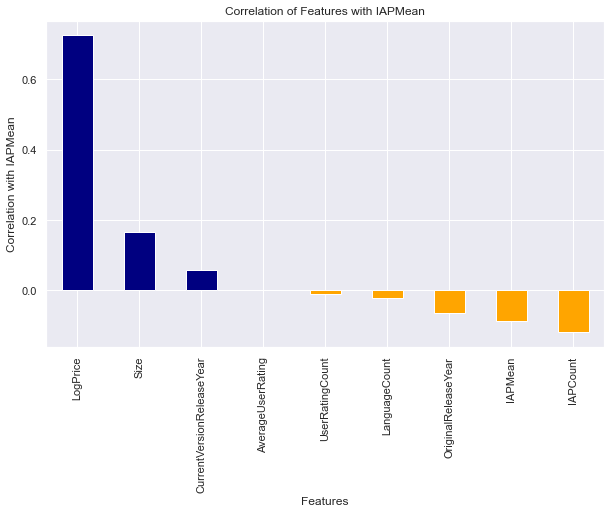

In [47]:
numeric_df = games_df.select_dtypes(include='number')
correlation_with_IAPMean = numeric_df.corr()['Price'].drop('Price').sort_values(ascending=False)
correlation_with_IAPMean = correlation_with_IAPMean[~correlation_with_IAPMean.index.str.startswith('Genres_')]

# Define custom colors for the bars
colors = ['navy' if val > 0 else 'orange' for val in correlation_with_price]

# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
correlation_with_IAPMean.plot(kind='bar', color=colors)
plt.xlabel('Features')
plt.ylabel('Correlation with IAPMean')
plt.title('Correlation of Features with IAPMean')
plt.show()

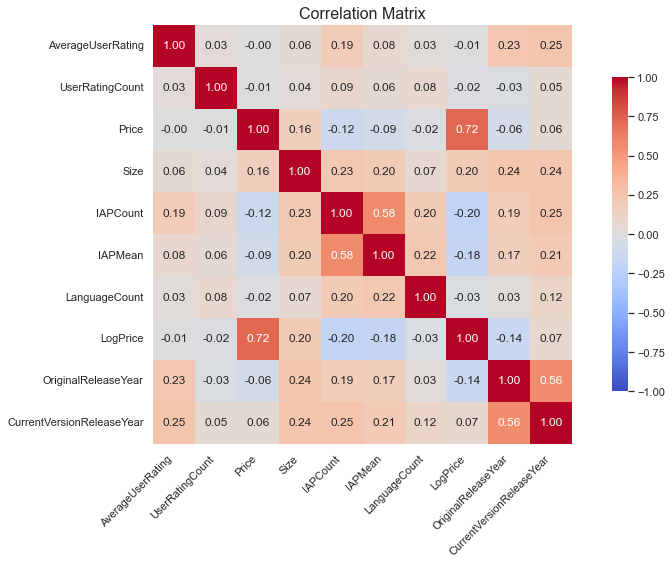

In [48]:
# Exclude dummy Genre columns
filtered_df = numeric_df.loc[:, ~numeric_df.columns.str.startswith('Genres_')]

# Compute correlation matrix
corr_matrix = filtered_df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    vmin=-1, vmax=1, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': 0.75}
)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Preparation

To prepare the dataset for machine learning, we proposed two methods: one for **tree-based models** and one for **linear/non-tree models**. For both methods:
- Dropped `Languages` and replaced with `LanguageCount`
- Replaced `Developer` with column `DeveloperGameCount` indicating the number of games the developer published
- One-hot encoded `GenresList` with `Genres_XXX` columns (already applied)
- Replaced `OriginalReleaseDate` and `CurrentVersionReleaseDate` with only the year and convert to `AppAge`
- Label encoded `AgeRating`
- Log-transform `Size`, `UserRatingCount`, `IAPMean`, `Price`
- Dropped `IAPCount` as it leaked information about `IAPMean`

Tree-based Models:
- Label encoded `PrimaryGenre`

Linear Models:
- One-hot encoded `PrimaryGenre`
- Applied StandardScaler and Principal Component Analysis (PCA) for feature normalization and dimensionality reduction

In [49]:
games_df.columns

Index(['Subtitle', 'AverageUserRating', 'UserRatingCount', 'Price',
       'Developer', 'AgeRating', 'Languages', 'Size', 'PrimaryGenre', 'Genres',
       'OriginalReleaseDate', 'CurrentVersionReleaseDate', 'IAPCount',
       'IAPMean', 'LanguageCount', 'LogPrice', 'Lang_Bin',
       'OriginalReleaseYear', 'CurrentVersionReleaseYear', 'GenresList',
       'Genres_Action', 'Genres_Adventure', 'Genres_Board', 'Genres_Books',
       'Genres_Business', 'Genres_Card', 'Genres_Casino', 'Genres_Casual',
       'Genres_Education', 'Genres_Emoji & Expressions',
       'Genres_Entertainment', 'Genres_Family', 'Genres_Finance',
       'Genres_Food & Drink', 'Genres_Games', 'Genres_Gaming',
       'Genres_Health & Fitness', 'Genres_Kids & Family', 'Genres_Lifestyle',
       'Genres_Magazines & Newspapers', 'Genres_Medical', 'Genres_Music',
       'Genres_Navigation', 'Genres_News', 'Genres_Photo & Video',
       'Genres_Productivity', 'Genres_Puzzle', 'Genres_Racing',
       'Genres_Reference', 'G

In [50]:
# Drop Languages, OriginalReleaseDate, CurrentVersionReleaseDate, GenresList columns to reduce dimensionality
games_df = games_df.drop(columns=[
    'Languages', 
    'OriginalReleaseDate', 
    'CurrentVersionReleaseDate', 
    'GenresList',
    'Lang_Bin',
    'Genres'
])

In [51]:
# Count games per developer
dev_counts = games_df['Developer'].value_counts()

# Map the count to a new column
games_df['DeveloperGameCount'] = games_df['Developer'].map(dev_counts)

# Drop original Developer column
games_df = games_df.drop(columns=['Developer'])

In [52]:
# Subtitle: not_empty(1) NaN(0)
games_df['Subtitle'] = games_df['Subtitle'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [53]:
# Create AppAge column
current_year = datetime.now().year
games_df['AppAge'] = current_year - games_df['OriginalReleaseYear']
games_df['VersionAge'] = current_year - games_df['CurrentVersionReleaseYear']

# Delete columns
games_df = games_df.drop(columns=['OriginalReleaseYear', 'CurrentVersionReleaseYear'])

In [54]:
# Initialize encoders for AgeRating 
le_age = LabelEncoder()

# Apply label encoding
games_df['AgeRating'] = le_age.fit_transform(games_df['AgeRating'])

In [55]:
# Log transform
games_df['LogSize'] = np.log1p(games_df['Size'])
games_df['LogUserRatingCount'] = np.log1p(games_df['UserRatingCount'])
games_df['LogPrice'] = np.log1p(games_df['Price'])
games_df['LogIAPMean'] = np.log1p(games_df['IAPMean'])

# Delete columns
games_df = games_df.drop(columns=['Size', 'UserRatingCount', 'Price', 'IAPMean', 'IAPCount'])

In [56]:
# Separate two datasets: one for tree-based models and one for lienar models
tree_games_df = games_df.copy()
linear_games_df = games_df.copy()

In [57]:
# Initialize encoders for PrimaryGenre 
le_primarygenre = LabelEncoder()

# Apply label encoding
tree_games_df['PrimaryGenre'] = le_primarygenre.fit_transform(tree_games_df['PrimaryGenre'])

In [58]:
tree_games_df.head(5)

,Subtitle,AverageUserRating,AgeRating,PrimaryGenre,LanguageCount,LogPrice,Genres_Action,Genres_Adventure,Genres_Board,Genres_Books,...,Genres_Trivia,Genres_Utilities,Genres_Weather,Genres_Word,DeveloperGameCount,AppAge,VersionAge,LogSize,LogUserRatingCount,LogIAPMean
0,0,4.0,2,6,17,1.383791,0,0,0,0,...,0,0,0,0,9,17,8,16.578905,8.175829,0.0
1,0,3.5,2,6,1,1.095273,0,0,1,0,...,0,0,0,0,1,17,7,16.327462,5.652489,0.0
2,0,3.0,2,6,1,0.000000,0,0,1,0,...,0,0,0,0,2,17,8,13.422197,9.033245,0.0
3,0,3.5,2,6,17,0.000000,0,0,0,0,...,0,0,0,0,9,17,8,16.885985,12.156856,0.0
4,0,3.5,2,6,15,1.383791,0,0,1,0,...,0,0,0,0,1,17,7,17.361934,3.367296,0.0


In [59]:
# Apply one hot encoding for PrimaryGenre
one_hot_genre = pd.get_dummies(linear_games_df['PrimaryGenre'], prefix='PrimaryGenre')

# Drop original PrimaryGenre and concatenate encoded version
linear_games_df = linear_games_df.drop(columns=['PrimaryGenre'])
linear_games_df = pd.concat([linear_games_df, one_hot_genre], axis=1)

In [60]:
linear_games_df.columns

Index(['Subtitle', 'AverageUserRating', 'AgeRating', 'LanguageCount',
       'LogPrice', 'Genres_Action', 'Genres_Adventure', 'Genres_Board',
       'Genres_Books', 'Genres_Business', 'Genres_Card', 'Genres_Casino',
       'Genres_Casual', 'Genres_Education', 'Genres_Emoji & Expressions',
       'Genres_Entertainment', 'Genres_Family', 'Genres_Finance',
       'Genres_Food & Drink', 'Genres_Games', 'Genres_Gaming',
       'Genres_Health & Fitness', 'Genres_Kids & Family', 'Genres_Lifestyle',
       'Genres_Magazines & Newspapers', 'Genres_Medical', 'Genres_Music',
       'Genres_Navigation', 'Genres_News', 'Genres_Photo & Video',
       'Genres_Productivity', 'Genres_Puzzle', 'Genres_Racing',
       'Genres_Reference', 'Genres_Role Playing', 'Genres_Shopping',
       'Genres_Simulation', 'Genres_Social Networking', 'Genres_Sports',
       'Genres_Stickers', 'Genres_Strategy', 'Genres_Travel', 'Genres_Trivia',
       'Genres_Utilities', 'Genres_Weather', 'Genres_Word',
       'Developer

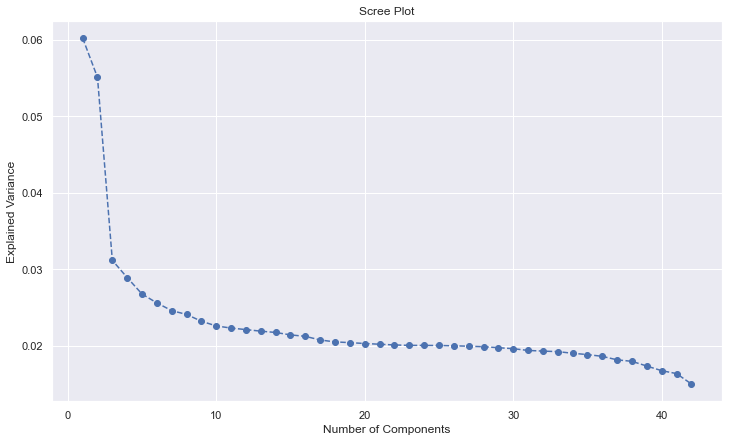

In [61]:

# Select only numeric columns for scaling and PCA
X = linear_games_df.drop(columns=['LogIAPMean']) 
X = X.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# See how much variance each component explains
explained_variance = pca.explained_variance_ratio_

# Plot the scree plot
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [62]:
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,0.046117,-1.677157,-1.272487,0.889608,0.113579,-2.545551,-1.738660,-0.728588,-0.415393,-0.040280,...,1.095501,0.193041,0.525708,0.572042,0.456496,0.375518,-0.050234,-1.187806,-1.568878,-0.021825
1,0.131325,-2.063536,-0.545904,2.895253,0.987660,-1.336586,0.652030,-0.213863,0.239179,-0.238742,...,0.510879,-0.509427,-0.450241,-0.334383,-0.454629,0.267610,0.141962,0.073450,-0.097920,-0.406721
2,0.294858,-3.190441,-0.582728,2.221930,0.432971,-1.494582,0.626519,-0.142669,-0.509369,-0.538156,...,0.811359,-0.622517,-0.669456,-0.172747,-0.123245,0.085933,0.500968,0.625449,1.669513,-0.727495
3,0.009765,-1.466402,-1.703704,0.129771,-0.571981,-2.524979,-1.838648,-0.580952,-1.030740,-0.424128,...,1.206963,0.197190,0.277231,0.747410,0.690946,-0.039090,0.189975,-0.490758,0.113138,-0.315666
4,0.062736,-1.725982,0.575610,4.196679,1.827452,-2.880023,0.026872,0.013448,0.780460,-1.930785,...,0.406200,0.920006,-0.017635,0.760265,0.024251,-1.713136,0.338323,0.061254,-0.346538,0.385498


# Modelling - Regressors

We begin by setting `LogIAPMean` as the target for models. We will test different ML techniques for model comparisons.

Tree-based Models:
- Random Forest Regressor
- XGB Regressor
- AdaBoost Regressor
  
Linear Models:
- Linear Regression
- Support Vector Regressor (SVR)
- KNN Regressor

In [63]:
features = tree_games_df.columns.values

X = tree_games_df.drop(columns='LogIAPMean')
y = tree_games_df['LogIAPMean'] 

Split the dataset into 75% training data and 25% testing data.

In [64]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

In [65]:
# Define function to print model results
def print_model_performance(y_train, y_test, train_preds, test_preds):
    
    # Print model performance
    print("Train R² Score:", r2_score(y_train, train_preds))
    print("Test R² Score:", r2_score(y_test, test_preds))
    
    print("Train MAE:", mean_absolute_error(y_train, train_preds))
    print("Test MAE:", mean_absolute_error(y_test, test_preds))
    
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))

## Tree-based Models

### RandomForestRegressor

In [66]:
# Initialize model
rfr = RandomForestRegressor(random_state=1)

# Fit the model
rfr.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = rfr.predict(X_train)
test_preds = rfr.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

Train R² Score: 0.9251742492776722
Test R² Score: 0.47054961910957926
Train MAE: 0.241535062155016
Test MAE: 0.6431785542912157
Train RMSE: 0.31462661200200515
Test RMSE: 0.8377490031598603


The model demonstrated a strong fit on the training data (R² = 0.93, MAE = 0.24, RMSE = 0.31), but has poor perforamce on the test set (R² = 0.47, MAE = 0.64, RMSE = 0.84)., suggesting overfitting and weak generalization. Further tuning is required to improve prediction error on unseen data.

In [67]:

# Define hyperparameter distributions for RFR
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Randomized search setup
rfr_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=1),
    param_distributions=param_dist,
    n_iter=50,           
    cv=5,
    n_jobs=-1,
    random_state=1,
    scoring='neg_mean_absolute_error' 
)

# Fit on training data
rfr_search.fit(X_train, y_train.values.ravel())

# Output best parameters
print("Best parameters found:", rfr_search.best_params_)


Best parameters found: {'max_depth': 23, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 379}


In [68]:
# Make predictions
train_preds = rfr_search.predict(X_train)
test_preds = rfr_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

Train R² Score: 0.8760045428902989
Test R² Score: 0.46873231284640215
Train MAE: 0.30874286109803645
Test MAE: 0.6457886524239222
Train RMSE: 0.40501657735292856
Test RMSE: 0.8391855327916689


### XGBRegressor

In [69]:
# Initialize model
xgb = XGBRegressor(random_state=1, n_jobs=-1, verbosity=0)

# Fit the model
xgb.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)


Train R² Score: 0.8233426085311327
Test R² Score: 0.448831971900185
Train MAE: 0.35961910037775174
Test MAE: 0.65432707587907
Train RMSE: 0.48343247254990696
Test RMSE: 0.8547582393815601


In [70]:

# Define hyperparameter distributions for XGB
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

# Randomized search setup
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=1, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=50,           
    cv=5,
    n_jobs=-1,
    random_state=1,
    scoring='neg_mean_absolute_error'
)

# Fit on training data
xgb_search.fit(X_train, y_train.values.ravel())

# Output best parameters
print("Best parameters found:", xgb_search.best_params_)


Best parameters found: {'colsample_bytree': 0.738515406246792, 'gamma': 0.2885338153158085, 'learning_rate': 0.04795784746912161, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 379, 'subsample': 0.9811324494882864}


In [71]:
# Make predictions
train_preds = xgb_search.predict(X_train)
test_preds = xgb_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

Train R² Score: 0.8787202510436056
Test R² Score: 0.473617012193266
Train MAE: 0.2966123067992948
Test MAE: 0.6412958844626214
Train RMSE: 0.4005567521094814
Test RMSE: 0.8353187109775665


### AdaBoostRegressor

In [3]:

# Initialize model
estimator = DecisionTreeRegressor(max_depth=5)
ada = AdaBoostRegressor(estimator=estimator, n_estimators=75, learning_rate=0.1, random_state=1)

# Fit the model
ada.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = ada.predict(X_train)
test_preds = ada.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)


TypeError: __init__() got an unexpected keyword argument 'estimator'

In [ ]:

# Define parameter distribution
param_dist_ada = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 1.0),
    'estimator__max_depth': randint(1, 10)  # Tuning the base decision tree
}

# Setup AdaBoost with DecisionTreeRegressor as base estimator
base_estimator = DecisionTreeRegressor(random_state=1)
ada = AdaBoostRegressor(estimator=base_estimator, random_state=1)

# RandomizedSearchCV
ada_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist_ada,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=1,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
ada_search.fit(X_train, y_train.values.ravel())

# Output best parameters
print("Best parameters found:", ada_search.best_params_)


In [ ]:
# Make predictions
train_preds = ada_search.predict(X_train)
test_preds = ada_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

## Linear Models

In [ ]:
# Select target variable
y = linear_games_df['LogIAPMean']
# X = linear_games_df.drop(columns='LogIAPMean')
# pca_df

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1
)

### Linear Regression

In [ ]:
# Initialize model
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)


### Support Vector Regressor

In [ ]:

# Initialize model
svr = SVR(kernel='rbf') 

# Fit the model
svr.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = svr.predict(X_train)
test_preds = svr.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

In [ ]:
# Define hyperparameter distributions
svr_param_dist = {
    'C': uniform(0.1, 10),         
    'epsilon': uniform(0.01, 1.0),  
    'gamma': ['scale', 'auto'],       
}

# Setup RandomizedSearchCV
svr_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=svr_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',  
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit to training data
svr_search.fit(X_train, y_train.values.ravel())
print("Best SVR parameters:", svr_search.best_params_)


In [ ]:
# Make predictions
train_preds = svr_search.predict(X_train)
test_preds = svr_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

### KNN Regressor

In [ ]:
# Initialize model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)


In [ ]:

# Define hyperparameter distributions
knn_param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform'],
    'p': [1, 2] 
}

# Setup RandomizedSearchCV
knn_search = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=knn_param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit to training data
knn_search.fit(X_train, y_train.values.ravel())
print("Best KNN parameters:", knn_search.best_params_)


In [ ]:
# Make predictions
train_preds = knn_search.predict(X_train)
test_preds = knn_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

### Model Comparisons

xgb: Best parameters found: {'colsample_bytree': np.float64(0.9318413437576735), 'gamma': np.float64(0.13652498710837369), 'learning_rate': np.float64(0.02777296039046904), 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 487, 'subsample': np.float64(0.8686616389688537)}
linear regression

In [ ]:
# Make predictions for the two best models
xgb_train_preds = xgb_search.predict(X_train)
xgb_test_preds = xgb_search.predict(X_test)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# XGBoost Regressor
sns.scatterplot(x=y_test, y=xgb_test_preds, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[0].set_xlabel("Actual Log-transformed IAPMean")
axes[0].set_ylabel("Predicted Log-transformed IAPMean")
axes[0].set_title("XGBoost Regressor")

# Linear Regression
sns.scatterplot(x=y_test, y=lr_test_preds, ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[1].set_xlabel("Actual Log-transformed IAPMean")
axes[1].set_ylabel("") 
axes[1].set_title("Linear Regression")

plt.suptitle("Actual vs Predicted Values", fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:

# Inverse-transform predictions 
actual_iap = np.expm1(y_test)             
xgb_preds_iap = np.expm1(xgb_test_preds)
lr_preds_iap = np.expm1(lr_test_preds)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# XGBoost Regressor
sns.scatterplot(x=actual_iap, y=xgb_preds_iap, ax=axes[0])
axes[0].plot([actual_iap.min(), actual_iap.max()], [actual_iap.min(), actual_iap.max()], '--r')
axes[0].set_xlabel("Actual IAPMean (USD)")
axes[0].set_ylabel("Predicted IAPMean (USD)")
axes[0].set_title("XGBoost Regressor")

# Linear Regression
sns.scatterplot(x=actual_iap, y=lr_preds_iap, ax=axes[1])
axes[1].plot([actual_iap.min(), actual_iap.max()], [actual_iap.min(), actual_iap.max()], '--r')
axes[1].set_xlabel("Actual IAPMean (USD)")
axes[1].set_ylabel("") 
axes[1].set_title("Linear Regression")

plt.suptitle("Actual vs Predicted In-App Purchase Mean (USD)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate residuals
xgb_residuals = actual_iap - xgb_preds_iap
lr_residuals = actual_iap - lr_preds_iap

# Plot residuals side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# XGBoost Residual Plot
sns.scatterplot(x=xgb_preds_iap, y=xgb_residuals, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted IAPMean (USD)")
axes[0].set_ylabel("Residual (USD)")
axes[0].set_title("XGBoost Regressor Residuals")

# Linear Regression Residual Plot
sns.scatterplot(x=lr_preds_iap, y=lr_residuals, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted IAPMean (USD)")
axes[1].set_ylabel("") 
axes[1].set_title("Linear Regression Residuals")

plt.suptitle("Residual Plots: Predicted vs Residuals", fontsize=14)
plt.tight_layout()
plt.show()


### Modelling - Classifiers

As f-1 score balances the precision and recall, we will evaluate the result based on weighted f-1 score and testing accuracy

In [73]:
#Evaluate result
print("Accuracy from 70% train data:",accuracy_score(y_train, pred_train, normalize=True, sample_weight=None)*100,"%")
print("Accuracy from 30% test data:",accuracy_score(y_test, pred_test, normalize=True, sample_weight=None)*100,"%")
print("Classification Report:", '\n', classification_report(y, pred_y))
print("Confusion Matrix:", '\n',confusion_matrix(y, pred_y))

Accuracy from 70% train data: 85.79469086021506 %
Accuracy from 30% test data: 84.47971781305115 %
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     14236
           1       0.64      0.20      0.30      2464
           2       0.85      0.25      0.39       275
           3       0.39      0.41      0.40        32

    accuracy                           0.85     17007
   macro avg       0.69      0.46      0.50     17007
weighted avg       0.83      0.85      0.82     17007

Confusion Matrix: 
 [[13958   256     6    16]
 [ 1970   484     6     4]
 [  185    21    69     0]
 [   19     0     0    13]]


In [ ]:
#Import cross validation 
from sklearn.model_selection import cross_val_score

In [75]:
#20-fold Cross validation score
score_cv = cross_val_score(final_model, X, y, cv=20)
score_cv

array([0.59694477, 0.69095182, 0.77438308, 0.81786134, 0.83078731,
       0.84018801, 0.84018801, 0.84941176, 0.84470588, 0.82117647,
       0.83176471, 0.84      , 0.82941176, 0.83764706, 0.84235294,
       0.84705882, 0.84      , 0.84117647, 0.83764706, 0.82823529])

Find the 20-fold cross valiadation score.

In [76]:
print("20-fold crossvalidation score:",score_cv.mean())

20-fold cross-validation score: 0.8140946291560104


As the cross validation score implies a similar score with the accuracy, it shows that the model can be used for future prediction of the range of price. For business purposes, developers can set the best range of price to maximize profit by adjusting other features based on the outcomes for future games_df.